Perform Facial Recognition with Deep Learning in Keras Using CNN

**DESCRIPTION**

Facial recognition is a biometric alternative that measures unique characteristics of a human face. Applications available today include flight check in, tagging friends and family members in photos, and “tailored” advertising. You are a computer vision engineer who needs to develop a
face recognition programme with deep convolutional neural networks.

**Objective:** Use a deep convolutional neural network to perform facial recognition using Keras.

**Dataset Details:**

ORL face database composed of 400 images of size 112 x 92. There are 40 people, 10 images per person. The images were taken at different times, lighting and facial expressions. The faces are in an upright position in frontal view, with a slight left-right rotation.

**Link to the Dataset:** https://www.dropbox.com/s/i7uzp5yxk7wruva/ORL_faces.npz?dl=0

**Prerequisites:**
Keras
Scikit Learn
Steps to be followed:
1. Input the required libraries
2. Load the dataset after loading the dataset, you have to normalize every image.
3. Split the dataset
4. Transform the images to equal sizes to feed in CNN
5. Build a CNN model that has 3 main layers:

i. Convolutional Layer
ii. Pooling Layer
iii. Fully Connected Layer

6. Train the model
7. Plot the result
8. Iterate the model until the accuracy is above 90%

###Instal library

In [ ]:
!pip install livelossplot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


###Import TensorFlow and other necessary libraries:

In [ ]:
import math
import numpy as np
from numpy.fft import fft2, ifft2
import pandas as pd
import os
import shutil
import pathlib
import PIL
import cv2

from livelossplot import PlotLossesKerasTF
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Input, Model

####Functions

In [ ]:
def createDirectory(path):
  # checking if the directory demo_folder
  # exist or not
  if not os.path.exists(path):
    # if the demo_folder directory is not present
    # then create it
    os.makedirs(path)

###Data aquisition

In [ ]:
#read train feature data
np_train_X = np.load('/content/trainX.npy')
#read train target data
np_train_y = np.load('/content/trainY.npy')

In [ ]:
#read test feature data
np_test_X = np.load('/content/testX.npy')
#read test target data
np_test_y = np.load('/content/testY.npy')

####Data augmentation

#####Distorsion function

In [ ]:
def disc(size):
  r = int(size / 2)
  y,x = np.ogrid[-r: r+1, -r: r+1]
  mask = x**2+y**2 > r**2
  np_disc = np.ones((size, size))
  np_disc[mask] = 0
  np_disc = np_disc / (np_disc.sum() + 1)
  return np_disc

In [ ]:
def disc_rand(size):
  if (size == 1):
    np_disc = np.array([np.random.uniform(low=0.01, high=0.091, size=1)])
  else:
    r = int(size / 2)
    y,x = np.ogrid[-r: r+1, -r: r+1]
    mask = x**2+y**2 > r**2
    np_disc = np.random.uniform(low=0.01, high=0.091, size=(size, size))
    np_neg_idx_x, np_neg_idx_y  = np.random.randint(low=0, high=(size-1), size=2).flatten()
    np_disc[np_neg_idx_x, np_neg_idx_y] *= -1.
    np_disc[mask] = 0
    np_disc = np_disc / (np_disc.sum() + 1)
  return np_disc

In [ ]:
def noise(np_array):
  sign_ = np.random.randint(low=-10, high=10, size=1)[0]
  size_ = np.prod(np_array.shape)
  tmp_data = np_array.reshape(size_)
  np_noise = np.random.randint(10, size=size_)
  if (sign_ > 0):
    tmp_data = np.array(tmp_data + np_noise)
    np_idx_pos = np.argwhere(tmp_data > 255)
    tmp_data[np_idx_pos] = 255
  else:
    tmp_data = np.array(tmp_data - np_noise)
    np_idx_neg = np.argwhere(tmp_data < 0)
    tmp_data[np_idx_neg] = 0
  tmp_data = np.array(tmp_data, dtype=np.uint8).reshape(np_array.shape)
  return tmp_data

In [ ]:
def rotationAndNoise(np_data):
  theta = np.random.uniform(low=-180., high=180., size=1)[0]
  hight, width, channel = np_data.shape
  M = cv2.getRotationMatrix2D((width / 2, hight / 2), theta, 1)
  tmp_data = cv2.warpAffine(np_data, M, (width, hight))
  tmp_data = noise(tmp_data)
  return tmp_data

In [ ]:
#randomly flips numpy array
def flipArray(np_array):
  flip_arr = [1, -1, 1, -1, -1, 1, 1]
  np.random.shuffle(flip_arr)
  np_array = np_array[::flip_arr[0],::flip_arr[1]]
  return np_array


In [ ]:
def Wiener(np_data):
  size_kernel = np.random.randint(low=1, high=5, size=1)[0]
  if ((size_kernel % 2) == 0):
    size_kernel += 1
  lst_wiener.append({'size_kernel':size_kernel})
  isDisc = ((np.random.randint(low=-10, high=10, size=1)[0]) > 0)
  lst_wiener.append({'isDisc':isDisc})
  if (isDisc):
    tmp_kernel = disc(size_kernel)
    Lambda = np.random.uniform(low=0.21, high=0.9, size=1)[0]
  else:
    tmp_kernel = disc_rand(size_kernel)
    Lambda = np.random.uniform(low=0.25, high=0.5, size=1)[0]
  lst_wiener.append({'tmp_kernel':tmp_kernel})
  lst_wiener.append({'Lambda':Lambda})

  hight, width, channel = np_data.shape

  pad_hight, pad_width = hight - size_kernel, width - size_kernel
  tmp_kernel = np.pad(tmp_kernel,((0, pad_hight), (0, pad_width)))
  tmp_fft2_kernel = fft2(tmp_kernel)
  w = np.conj(tmp_fft2_kernel) / (np.conj(tmp_fft2_kernel) * tmp_fft2_kernel + Lambda)
  out = np.real(ifft2(w * fft2(np_data[:,:,0])))

  return out

#####Data generation

In [ ]:
#create a list of augmented function
lst_augmentation_func = [noise, rotationAndNoise, Wiener]

def data_augmentation(np_array_X, np_array_y, nbr_gen_for_sample):
  tmp_X = np_array_X.copy()
  tmp_y = np_array_y.copy()
  shape_ = np_array_X[0].shape
  for i in range(nbr_gen_for_sample):
    lst_gen_arr = []
    for np_data in np_array_X:
      idx_img_gen = np.random.randint(low=0, high=3, size=1)[0]
      lst_idx_gen.append(idx_img_gen)
      tmp_np_gen_arr = lst_augmentation_func[idx_img_gen](np_data)
      tmp_np_gen_arr = flipArray(tmp_np_gen_arr).reshape(shape_)
      lst_gen_arr.append(tmp_np_gen_arr)

    np_gen_arr = np.array(lst_gen_arr)
    tmp_X = np.concatenate((tmp_X, np_gen_arr), axis=0)
    tmp_y = np.concatenate((tmp_y, np_array_y), axis=0)

  return tmp_X, tmp_y


In [ ]:
lst_idx_gen = []
lst_wiener = []
nbr_gen_for_sample = 10
np_train_X = np_train_X.reshape(np_train_X.shape[0], 112, 92, 1)
np_train_X, np_train_y = data_augmentation(np_train_X, np_train_y, nbr_gen_for_sample)

In [ ]:
lst_idx_gen = []
lst_wiener = []
nbr_gen_for_sample = 10
np_test_X = np_test_X.reshape(np_test_X.shape[0], 112, 92, 1)
np_test_X, np_test_y = data_augmentation(np_test_X, np_test_y, nbr_gen_for_sample)

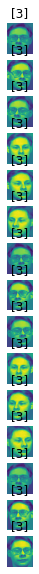

In [ ]:
plt.figure(figsize=(10, 10))
i = 0

idx_x = np.argwhere(np.array(np_train_y == 3))[:15]
for image, label in zip(np_train_X[idx_x], np_train_y[idx_x]):
  ax = plt.subplot(idx_x.shape[0], 1, i + 1)
  plt.imshow(image.reshape(112, 92))
  plt.title(label)
  plt.axis("off")
  i+=1

In [ ]:
def plot_rand_3_sample(np_array_X, np_array_y):
  plt.figure(figsize=(10, 10))
  i = 0

  idx_x = np.random.randint(low=0, high=np_array_X.shape[0], size=3)
  for image, label in zip(np_array_X[idx_x], np_array_y[idx_x]):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.reshape(112, 92))
    plt.title(label)
    plt.axis("off")
    i+=1

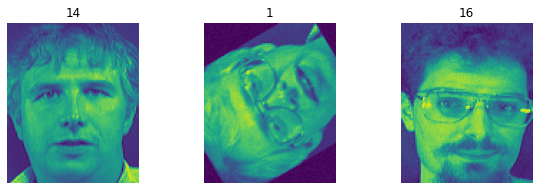

In [ ]:
plot_rand_3_sample(np_test_X, np_test_y)